# Part 1: Data Sourcing

### Imports

In [1]:
import os
import dotenv
import json
import requests

import pandas as pd

With this project I decided to analize [**NASA Small-Body Database**](https://ssd-api.jpl.nasa.gov/doc/sbdb_query.html). The archive compiles public datasets of small objects in the solar system such as asteroids and comets. It many many physical parameters of these objects. By analizing it, I want to investigate correlations between different parameters of the small objects in the solar system. Another obective of the analysis is to prove experimentaly the Kepler's 3rd law, which states the relationship between the major axis and the period of the orbit.

### Ideas for analysis
- find velocity destribution
- find diameter destribution
- find mass destribution
- brightness - discovery date relationship
- clothest prox to earth - diameter relationship
- experimental proof of the Kepler's 3rd law

### Requesting data from the API

### Field names
**full_name** - name of the asteroid with its catalog number  
**kind** - indicates whether asteroid (a) or comet (c) and whether numbered (n) or unnumbered (u)  
**n** - mean motion (deg/d)  
**diameter** - effective body diameter (km)  
**GM** - mass expressed as a product of the mass and gravitational constant  
**H** - absolute magnitude  
**soln_date** - date/time of orbit determination (YYYY-MM-DD HH:MM:SS)  
**moid** - minimum distance between the orbits of Earth and the small-body (au)  
**a** - semimajor axis (au)  
**per** - orbital period (d)

In [2]:
dotenv.load_dotenv()
NASA_KEY = os.getenv("NASA_KEY")
root = "https://ssd-api.jpl.nasa.gov"
endpoint = "/sbdb_query.api"

# Using the documentation listed all the fields that will be used in the analysis
extract_fields = "full_name,kind,n,diameter,GM,H,soln_date,moid,a,per"

In [3]:
params = {"fields": extract_fields}
r = requests.get(root + endpoint, params=params)
data_json = json.loads(r.text)
fields = extract_fields.split(",") # this line was generated by Copilot
df = pd.json_normalize(data_json, record_path=["data"])
df.columns = fields
df

,full_name,kind,n,diameter,GM,H,soln_date,moid,a,per
0,1 Ceres (A801 AA),an,0.2141,939.4,62.6284,3.34,2021-04-13 11:04:44,1.58,2.767,1.68e+03
1,2 Pallas (A802 FA),an,0.2138,513,13.63,4.12,2024-02-20 20:16:51,1.23,2.77,1.68e+03
2,3 Juno (A804 RA),an,0.226,246.596,None,5.17,2024-02-23 20:13:41,1.04,2.669,1.59e+03
3,4 Vesta (A807 FA),an,0.2715,525.4,17.288245,3.25,2021-04-13 11:15:57,1.14,2.362,1.33e+03
4,5 Astraea (A845 XA),an,0.2383,106.699,None,7.00,2024-02-20 20:16:50,1.11,2.577,1.51e+03
...,...,...,...,...,...,...,...,...,...,...
1355530,C/2024 B2 (Lemmon),cu,1.205e-06,None,None,None,2024-02-17 03:13:03,3.38,8747,2.99e+08
1355531,C/2024 C1 (PANSTARRS),cu,0.02874,None,None,None,2024-02-17 03:13:33,3.46,10.55,1.25e+04
1355532,C/2024 C2 (PANSTARRS),cu,0.01514,None,None,None,2024-02-14 23:42:05,8.12,16.18,2.38e+04
1355533,C/2024 C3 (PANSTARRS),cu,0.02484,None,None,None,2024-02-21 00:13:12,5.73,11.63,1.45e+04


# Part 2: Exploratory Data Analysis
The dataframe has information about 1,355,527 small-body objects. Let's see the datatypes that df consists of.

In [4]:
df.dtypes

full_name    object
kind         object
n            object
diameter     object
GM           object
H            object
soln_date    object
moid         object
a            object
per          object
dtype: object

Let's convert all quantitative columns (all columns except for *full_name*, *kind*, and *soln_date*) into float64 type. Then, convert the soln_date into a padas datetime object.

In [5]:
quantitative_columns = ["n", "diameter", "GM", "H", "moid", "a", "per"] # this line was generated by Copilot
df[quantitative_columns] = df[quantitative_columns].astype(float)
df['soln_date'] = pd.to_datetime(df['soln_date'])

In [6]:
df.dtypes

full_name            object
kind                 object
n                   float64
diameter            float64
GM                  float64
H                   float64
soln_date    datetime64[ns]
moid                float64
a                   float64
per                 float64
dtype: object

Now all columns have proper datatypes.

Let's see at the summary statistics of the numeric values of the dataframe.

In [7]:
df.describe()

,n,diameter,GM,H,soln_date,moid,a,per
count,1.353772e+06,139713.000000,1.600000e+01,1.350543e+06,1351704,1.351733e+06,1.353772e+06,1.353232e+06
mean,2.351428e-01,5.460229,6.770327e+00,1.744329e+01,2023-05-01 04:39:50.106229248,1.412118e+00,-3.200696e+05,1.572060e+06
min,3.455000e-18,0.002500,2.100000e-09,-1.230000e+00,2000-09-07 10:28:10,3.930000e-07,-4.333000e+11,1.150000e+02
25%,1.876000e-01,2.763000,5.047100e-07,1.657000e+01,2022-10-21 02:57:56.249999872,9.790000e-01,2.397000e+00,1.360000e+03
50%,2.268000e-01,3.949000,2.489450e-01,1.745000e+01,2023-10-09 18:38:42.500000,1.250000e+00,2.663000e+00,1.590000e+03
75%,2.656000e-01,5.732000,5.500000e+00,1.830000e+01,2024-02-21 20:34:09.500000,1.600000e+00,3.022000e+00,1.920000e+03
max,3.142000e+00,939.400000,6.262840e+01,3.358000e+01,2024-03-01 08:43:29,7.960000e+01,1.619000e+06,7.520000e+11
std,8.236574e-02,9.310241,1.581291e+01,1.825296e+00,NaN,2.083542e+00,3.724054e+08,7.457813e+08


### 1) Diameter
Looking more deeply into the diameter column, it is clear that the majority of the values lay between 2.76 and 5.73 km. However, the max value of 939.4 km looks like a complete outlier. Let's make some frequency charts in order to get a sense of what this data looks like.

<Axes: title={'center': 'Diameter of Small-Body Objects (km)'}, ylabel='Frequency'>

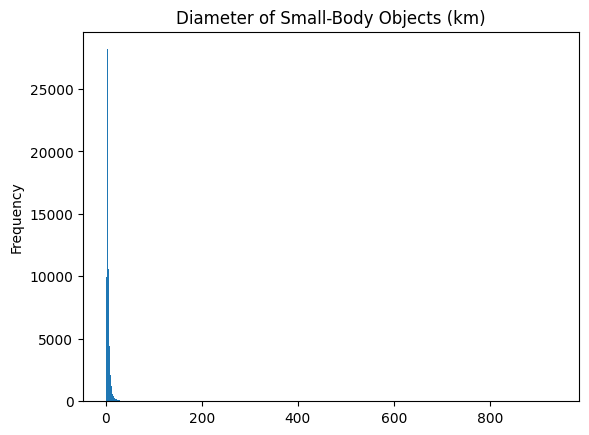

In [8]:
df["diameter"].plot.hist(bins=1000, title="Diameter of Small-Body Objects (km)")

As we can see, the spike on this graph is very clear, but the presence of the bell curve of the normal distribution is not too evident. That's why I devided this histogram into two smaller ones: one - from 0 to 100 km, and another one - from 100 to 1000 km on the x-axis. Then I scaled the second histogram so it's eathier to see the values distribution.

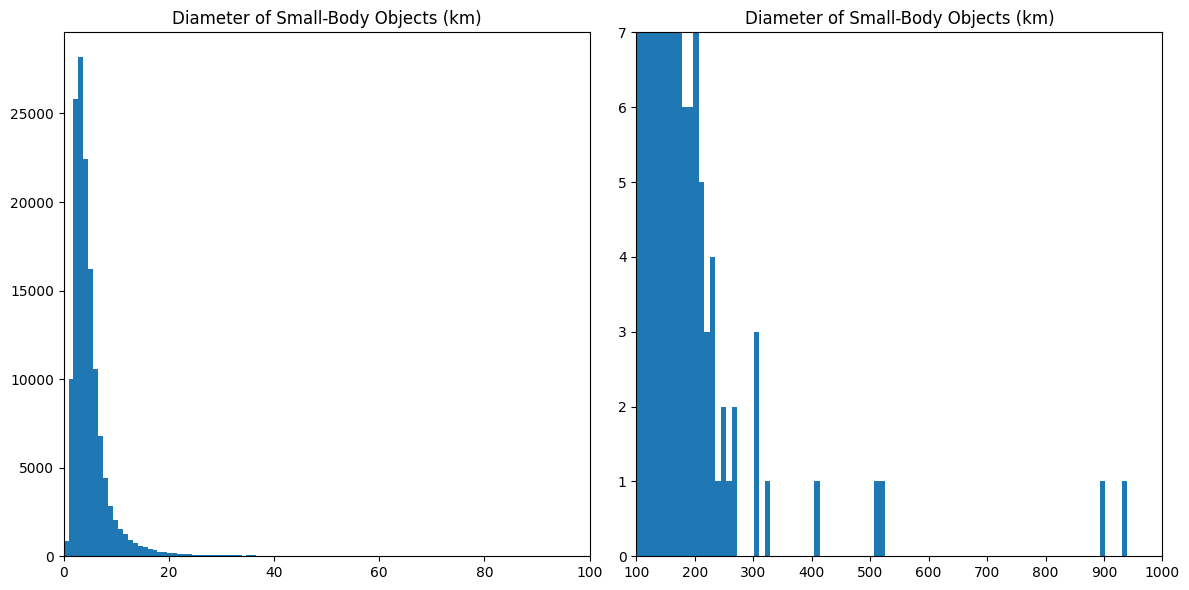

In [9]:
# Most of the following code was generated by Copilot
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot from 0 to 100
axs[0].hist(df["diameter"], bins=1000)
axs[0].set_title("Diameter of Small-Body Objects (km)")
axs[0].set_xlim(left=0, right=100)
# axs[0].set_ylim(bottom=0, top=7)

# Plot from 100 to 1000
axs[1].hist(df["diameter"], bins=100)
axs[1].set_title("Diameter of Small-Body Objects (km)")
axs[1].set_xlim(left=100, right=1000)
axs[1].set_ylim(bottom=0, top=7)

plt.tight_layout()
plt.show()

Here we can clearly see the normal distribution with a slow decrease in the number of values approaching the heigher diameters. Looking at the graph itself, the two values in the 900 km area seem wrong, but I decided to leave them anyways because all the measurments were done by professional scientists and are backed up with scientific papers.

### 2) Mass

Although this step of the precess only implies analizing the data and doesn't expect any manipulations with it, obtaining the masses of the small-body objects will require some processing of the *GM* column. G there stands for the gravitational constant which value is known. In order to find the mass values, the whole column has to be devided by the value of G.

In [10]:
G = 6.67430e-11 # m^3 kg^-1 s^-2 - gravitational constant
df["M"] = df["GM"] / G

Here is the distribution of the mass values:

<Axes: title={'center': 'Mass of Small-Body Objects (kg)'}, ylabel='Frequency'>

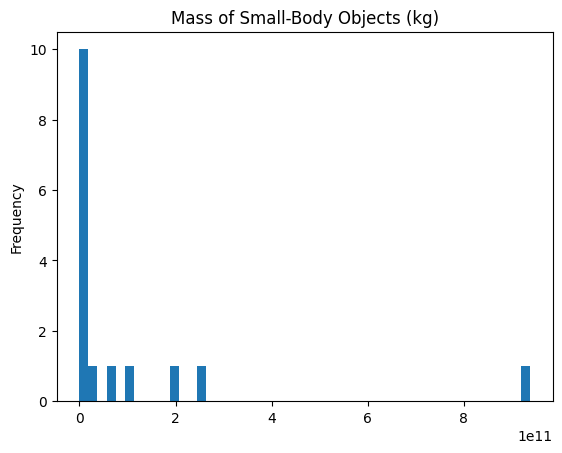

In [11]:
df["M"].plot.hist(bins=50, title="Mass of Small-Body Objects (kg)")

As we can see from the histogram, most of the values lay between 0 and 2e+11 kg. However it is dificult to get an understanding of the distribution of these values as there are only 16 of them in the databse. Also, one of the objects has a mass of more than 9e+11 kg. Maybe that is the same object that has a ridiculously big diameter. To find that out let's find the object with the biggest mass and see what diameter it has.

In [12]:
df[["M", "diameter", "kind"]].sort_values("M", ascending=False).loc[0]

M           938351587432.390015
diameter                  939.4
kind                         an
Name: 0, dtype: object

Indeed, this is the same object that had a diameter of approximately 939 km on a previous histogram.

### 3) Mean motion

Finally, let's look at the distribution of the values of mean angular velocities of the objects, as it will give us an understanding of how fast the majority of them is moving.

<Axes: title={'center': 'Mean Motion of Small-Body Objects (degrees/day)'}, ylabel='Frequency'>

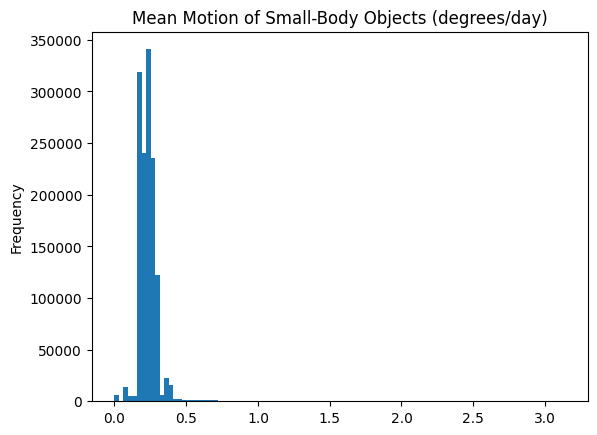

In [13]:
df["n"].plot.hist(bins=100, title="Mean Motion of Small-Body Objects (degrees/day)")

Most values are between 0 and 0.5 degrees per day, but because of the huge number of objects in that range, the right side of the plot is not visible. Let's split the histogram as we did earlier with diameter.

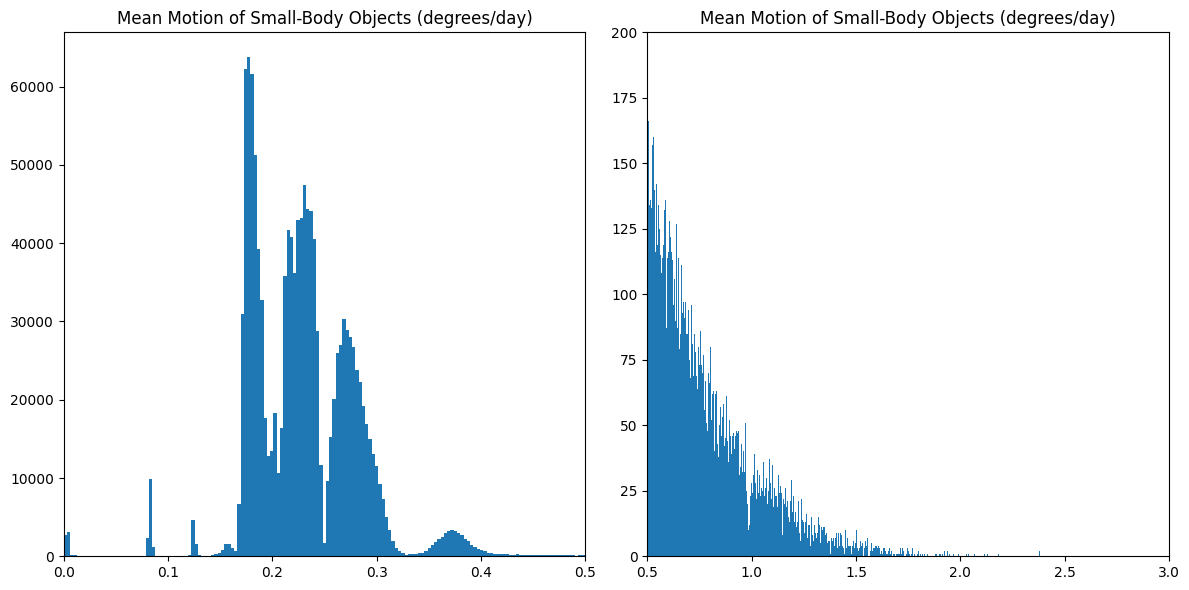

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot from 0 to 100
axs[0].hist(df["n"], bins=1000)
axs[0].set_title("Mean Motion of Small-Body Objects (degrees/day)")
axs[0].set_xlim(left=0, right=0.5)
# axs[0].set_ylim(bottom=0, top=7)

# Plot from 100 to 1000
axs[1].hist(df["n"], bins=1000)
axs[1].set_title("Mean Motion of Small-Body Objects (degrees/day)")
axs[1].set_xlim(left=0.5, right=3)
axs[1].set_ylim(bottom=0, top=200)

plt.tight_layout()
plt.show()

The histogram looks like it consists of at least four normal destributions which overlap.

# Part 3: Data Cleaning and Preparation
### Handling missing values
The data has already been transformed to a proper form, and necessary columns have been added, for the most part. Now the only thing left is dealing with the missing values. Although the data frame has *1355527* rows, a lot of them have missing values.

In [15]:
df.isnull().sum()

full_name          0
kind               0
n               1763
diameter     1215822
GM           1355519
H               4992
soln_date       3831
moid            3802
a               1763
per             2303
M            1355519
dtype: int64

The biggest sources of missing values are the coulmns *M* and *GM*. We can simply delete them sicne we won't need them in further analysis. 

In [16]:
df = df.drop(["M", "GM"], axis=1) # this line was generated by Copilot

Diameter column also has a lot of missing values, but it will still be used later on. So I decided to make a copy of the dataframe that consists of diameter. Other than that, the diameter will be removed as well. Once diameter is removed we can just go ahead and drop the NaN values for all other columns since they have very few missing values. Even if none of the missing values of these other columns overlap, the maximum lost of data would be 29237 records which is negligable compared to the size of the dataframe. 

In [17]:
df_diameter = df.dropna() # makes a copy of the dataframe that still has information about the diameter
df = df.drop(["diameter"], axis=1) # removes the diameter from the original dataframe
df = df.dropna()

df_diameter.isnull().sum(), df.isnull().sum()

(full_name    0
 kind         0
 n            0
 diameter     0
 H            0
 soln_date    0
 moid         0
 a            0
 per          0
 dtype: int64,
 full_name    0
 kind         0
 n            0
 H            0
 soln_date    0
 moid         0
 a            0
 per          0
 dtype: int64)

In [18]:
df_diameter.shape[0], df.shape[0]

(138961, 1348589)

As intended, neither of two dataframes have missing values. The original dataframe almost haven't lost any data, but the copy of the dataframe that still has the diameter value is now much smaller.

### Asteroids?
The datasets already have a column that indicates if the body is an asteroid or a comet, but it's not intuitive and hard to use in visualizations. Let's create a column named *asteroid* that would have a value 1 if the object is an asteroid, and 0 - if it's a comet.

In [19]:
df["asteroid"] = df["kind"].map({"an": 1, "au": 1, "cn": 0, "cu": 0})
df_diameter["asteroid"] = df_diameter["kind"].map({"an": 1, "au": 1, "cn": 0, "cu": 0})

df.tail() # tail because unlike head it actually has examples of both

,full_name,kind,n,H,soln_date,moid,a,per,asteroid
1351608,(6331 P-L),au,0.276100,18.50,2022-02-06 00:56:18,0.6720,2.336,1300.0,1
1351609,(6344 P-L),au,0.208000,20.40,2021-12-07 04:50:42,0.0366,2.821,1730.0,1
1354251,P/2005 XR132 (Spacewatch),cu,0.135200,16.44,2022-04-11 18:11:12,1.1900,3.759,2660.0,0
1354994,P/2014 VF40 (PANSTARRS),cu,0.127000,16.17,2024-02-29 10:08:14,1.1100,3.920,2830.0,0
1355228,C/2019 G2 (PANSTARRS),cu,0.000053,16.31,2021-04-15 21:07:54,1.4100,699.800,6760000.0,0


In [20]:
df["asteroid"].value_counts()

asteroid
1    1348586
0          3
Name: count, dtype: int64

In [21]:
df_diameter["asteroid"].value_counts()

asteroid
1    138961
Name: count, dtype: int64

It turned out that most of the remaining objects are asteroids, and there are only 3 comets in the original dataset. There are no comets in the "diameter" dataset. It's because most of the comets data had missing values.

# Part 4: Data Analysis and Visualization
### Clothest proximity to earth - diameter relationship
The question that concerns most people about the small objects in the solar system is wether they are going to collide with Earth, and if yes -  what the impact is gonna be. Let's find out asteroids of what size will come the closest to the Earth's orbit to see if we need to hurry up colonizing ohter planets.

<Axes: title={'center': 'Diameter vs Clothest Proximity to Earth'}, xlabel='Distance (au)', ylabel='Diameter (km)'>

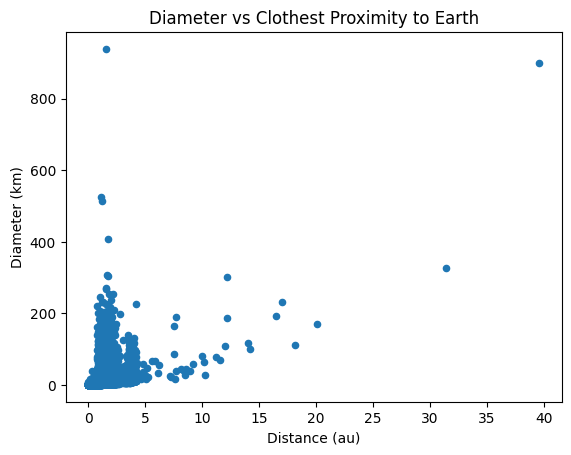

In [22]:
df_diameter.plot.scatter(x="moid", y="diameter", xlabel="Distance (au)", ylabel="Diameter (km)", title="Diameter vs Clothest Proximity to Earth")

It looks like most of the points are close to the origin, and also those are the ones that we care about the most, since they will be the closest to Earth. So let's zoom in on that region.

<Axes: title={'center': 'Diameter vs Clothest Proximity to Earth'}, xlabel='Distance (au)', ylabel='Diameter (km)'>

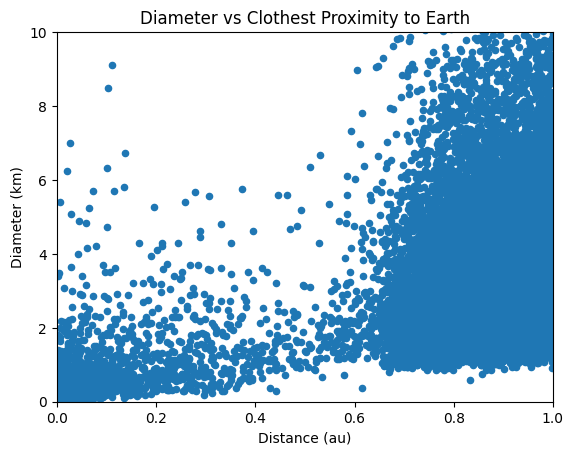

In [23]:
df_diameter.plot.scatter(x="moid", y="diameter", xlim=(0, 1), ylim=(0, 10), xlabel="Distance (au)", ylabel="Diameter (km)", title="Diameter vs Clothest Proximity to Earth")

As we can see, there are many asteroids either close to the Earth's orbit or exactly on it. Most of them are relatively small. With that said, we don't actually have to worry about colliding with any of them because almost all of them are located in the Lagrange points of the Earth's orbit, which is nowhere near the Earth. 

### Magnitude - discovery date relationship
It is pretty much common sense that brighter objects are easier to discover and measure the parameters of. So, I would predict that from looking at the dates of the discoveries (*soln_date* column) we will see a trend that would suggest that dimmer objects tend to be discovered later that the brighter ones.    

P.S. magnitude corresponds to reversed brightness, so the **brighter** objects will have **smaller** magnitude.

<Axes: title={'center': 'Magnitude vs Discovery Date'}, xlabel='Date', ylabel='Magnitude'>

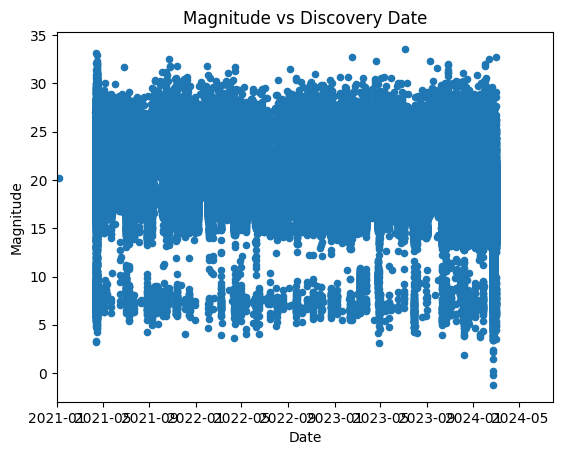

In [24]:
df.plot.scatter(x="soln_date", y="H", xlim=(pd.to_datetime('2021'), None), xlabel="Date", ylabel="Magnitude", title="Magnitude vs Discovery Date")

### Experimental proof of the Kepler's 3rd law

First let's look how the orbital period of the objects relates to their semimajor axis.

<Axes: title={'center': 'Orbital Period vs Semi-Major Axis'}, xlabel='Semi-Major Axis (au)', ylabel='Orbital Period (days)'>

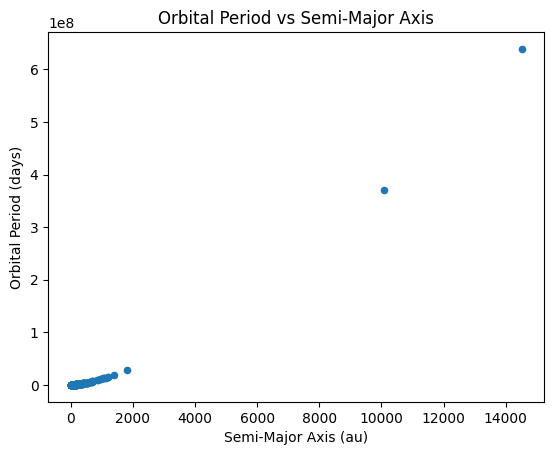

In [25]:
df.plot.scatter(x="a", y="per", xlabel="Semi-Major Axis (au)", ylabel="Orbital Period (days)", title="Orbital Period vs Semi-Major Axis")

We can clearly see some sort of a step function. This function is described by the Kepler's 3rd law. It states that the **squre** of the **orbital period** of the object is propotional to the **cube** of its **semimajor axis**. Let's create new coloumns for these values and then make a scatterplot. Also let's zoom in at the origin of that graph to make it more clear because all values are small except for a few outliers.    

Here I made new collumns for period squared and semimajor axis cubed.

In [26]:
df["a^3"] = df["a"] ** 3
df["per^2"] = df["per"] ** 2

df.head()

,full_name,kind,n,H,soln_date,moid,a,per,asteroid,a^3,per^2
0,1 Ceres (A801 AA),an,0.2141,3.34,2021-04-13 11:04:44,1.58,2.767,1680.0,1,21.184952,2822400.0
1,2 Pallas (A802 FA),an,0.2138,4.12,2024-02-20 20:16:51,1.23,2.770,1680.0,1,21.253933,2822400.0
2,3 Juno (A804 RA),an,0.2260,5.17,2024-02-23 20:13:41,1.04,2.669,1590.0,1,19.012784,2528100.0
3,4 Vesta (A807 FA),an,0.2715,3.25,2021-04-13 11:15:57,1.14,2.362,1330.0,1,13.177702,1768900.0
4,5 Astraea (A845 XA),an,0.2383,7.00,2024-02-20 20:16:50,1.11,2.577,1510.0,1,17.113674,2280100.0


<Axes: title={'center': 'Orbital Period^2 vs Semi-Major Axis^3'}, xlabel='Semi-Major Axis^3 (au^3)', ylabel='Orbital Period^2 (days^2)'>

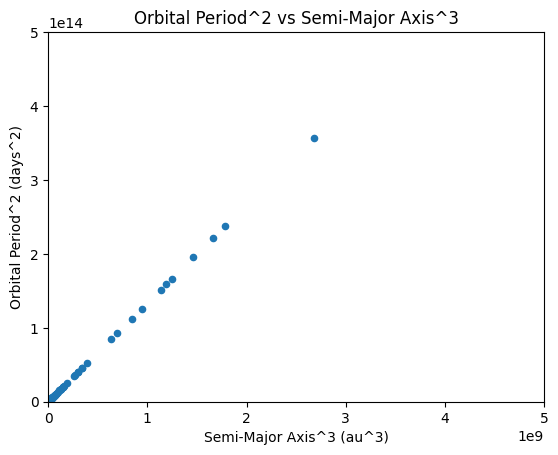

In [27]:
df.plot.scatter(x="a^3", y="per^2", xlim=(0, 0.5e10), ylim=(0, 0.5e15), xlabel="Semi-Major Axis^3 (au^3)", ylabel="Orbital Period^2 (days^2)", title="Orbital Period^2 vs Semi-Major Axis^3")

As predicted by the Kepler's law, these two values are indeed linearly propotional. Physics still works.

# Part 5: Conclusion
In this project, I requsted and analized data from the NASA Small-Body Database. Using pandas I was able to get an understanding of the data and its structure. By making distribution histograms of some physical parameters I saw that a lot of these values represent normal distribution, which was pretty expected. But what I didn't expect was the distribution histogram of mean motion, which seemed to consist of not one but quite many normal distributions (at least four major, and a couple of smaller ones which are harder to count precisely). This might suggest that the objects in the database don't make a homogeneous array, but can be organized into several distinct groups. I tried to look into some reasons for that but my efforts were fruitless.    

Besides that, I was able to draw some concluiusions about the data. By looking at the distances of these objects form the Earth's orbit and their diameter, I found that, luckily for us, most of the bigger asteroids are located pretty far from the Earth. However there are a lot of asteroids that lay exactly on the Earth's orbit, but they will never collide with us. If the physics works, of course. Which it seems to do, according to my other analyses where I looked at the correlation between the semimajor axis and the period of the orbit. By raising the period to the power of two, and semimajor axis - of three, I got a perfectly straight line and showed that Kepler wasn't burned at the stake for nothing. It's actually Bruno, Kepler died of a disease.    

However, the other vizualisation where I tried to show that more dimmer objects took longer to discover turned out inconclusive. This might be because most of these objects where discovered in the modern days. Modern equipment allows astronomers to check for all asteroids in a certain area rather than just looking at the brightest ones, so it actually makes sense that there is almost no correlation.

While working on this project I ran into many diffculties associated with the size of the database. It has over 1,300,000 records - way more than any dataset I've worked with so far. So I had to improvise many solutions as I went. For example, while plotting the normal distribution graphs for this massive number of diameter and mean motion values, I couldn't see the tails of the bell curve because the peak values were so big. I came up with plotting the same graph in two different scales, which allowed me to see better the overall shape of the curve in the most densely populated areas as well as the regions on the graph were there are only few values. These challenges made working on this project way more interesting.    

If I had more time to work on this project I would definitely come up with more visualizations. Also I would invest more time in investigating what exactly caused such an odd distribution of the mean motion values. I expect that I would've found out that there are several (anywhere from 4 to 10, based on the distribution graph) distinct groups of objects that would be similar to each other within the group, but way different compared to other groups.